In [32]:
import pickle, os
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm_notebook as tqdm
from keras.models import Sequential
import keras.layers
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM
from keras.layers import BatchNormalization
from keras.regularizers import L1L2
from keras.callbacks import EarlyStopping
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
import tensorflow as tf
from keras_tqdm import TQDMNotebookCallback

In [2]:
train, valid, test = pickle.load(open('dataset.pickle', 'rb'))
train = train.fillna(0)
valid = valid.fillna(0)
test = test.fillna(0)

c:\users\ychang\appdata\local\programs\python\python36\lib\site-packages\pandas\core\indexes\base.py:162: FutureWarning: the 'labels' keyword is deprecated, use 'codes' instead
  return cls.__new__(cls, **d)


In [3]:
train.shape, valid.shape, test.shape

((298911, 401), (30026, 401), (48409, 401))

In [3]:
feat_col = ['raw_acc','proc_gyro','raw_magnet','watch_acceleration','watch_heading', 'location', 'location_quick_features', 'audio_naive', 'audio_properties', 'discrete', 'lf_measurements']
scaler = MinMaxScaler()
train[feat_col] = scaler.fit_transform(train[feat_col])
test[feat_col] = scaler.transform(test[feat_col])
valid[feat_col] = scaler.transform(valid[feat_col])

In [19]:
x_train, y_train = train[feat_col], train.iloc[:,-8:]
x_val, y_val = valid[feat_col], valid.iloc[:,-8:]
x_test, y_test = test[feat_col], test.iloc[:,-8:]

In [7]:
latent, space = 3, 1
def transform_data(data, label):
    transformed_data, transformed_label = [], []
    users = set(data.index.get_level_values(0))
    for u in tqdm(users):
        d = data.loc[u]
        for i in tqdm(range(latent, len(d)), leave=False):
            transformed_data.append(d.iloc[i-latent:i+1:space])
            transformed_label.append(label.loc[u].iloc[i])
    return np.stack(transformed_data), np.stack(transformed_label)

In [10]:
x_val, y_val = transform_data(x_val, y_val)
pickle.dump((x_val, y_val), open('transformed_val.pickle', 'wb'))
x_test, y_test = transform_data(x_test, y_test)
pickle.dump((x_test, y_test), open('transformed_test.pickle', 'wb'))

In [20]:
#os.mkdir('train')
latent, space = 3, 1
users = set(x_train.index.get_level_values(0))
for u in tqdm(users):
    transformed_data, transformed_label = [], []
    d = x_train.loc[u]
    for i in tqdm(range(latent, len(d)), leave=False):
        transformed_data.append(d.iloc[i-latent:i+1:space])
        transformed_label.append(y_train.loc[u].iloc[i])
    pickle.dump((transformed_data, transformed_label), open('train/{}.pickle'.format(u), 'wb'))

In [ ]:
pickle.dump((x_train, y_train, x_val, y_val, x_test, y_test), open('transformed2.pickle', 'wb'))

In [28]:
#x_train, y_train = pickle.load( open('transformed_train.pickle', 'rb'))
x_val, y_val = pickle.load( open('transformed_val.pickle', 'rb'))
x_test, y_test = pickle.load( open('transformed_test.pickle', 'rb'))
x_train, y_train = [], []
for filename in tqdm(os.listdir('train')):
    tmp = pickle.load(open('train/'+filename, 'rb'))
    x_train += tmp[0]
    y_train += tmp[1]
x_train, y_train = np.stack(x_train), np.stack(y_train)

In [29]:
x_train.shape

(298767, 4, 225)

In [74]:
model = Sequential()
model.add(LSTM(512, input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2, noise_shape=None, seed=None))
model.add(BatchNormalization())
model.add(Dense(8, activation='relu'))
model.add(Dropout(0.2, noise_shape=None, seed=None))
model.add(BatchNormalization())
model.add(Dense(y_train.shape[1], activation='softmax'))
optim = keras.optimizers.SGD(lr=1e-3, momentum=0.0, decay=0.0, nesterov=False)
model.compile(loss='categorical_crossentropy', optimizer=optim, metrics=['accuracy'])

In [75]:
history = model.fit([x_train], batch_size=1024, y=y_train, verbose=0, validation_data=(x_val, y_val), shuffle=True,
          epochs=5, callbacks=[TQDMNotebookCallback(leave_inner=True, leave_outer=True)])

In [84]:
predicted = model.predict(x_test)
predicted = np.argmax(predicted, axis=1)
y_test_decode = np.argmax(y_test, axis=1)
print(accuracy_score(y_test_decode, predicted))

0.4403918083941229


In [80]:
history2 = model.fit([x_train], batch_size=1024, y=y_train, verbose=0, validation_data=(x_val, y_val), shuffle=True,
          epochs=5, callbacks=[TQDMNotebookCallback(leave_inner=True, leave_outer=True)])

In [76]:
predicted = model.predict(x_test)
predicted = np.argmax(predicted, axis=1)
y_test_decode = np.argmax(y_test, axis=1)
print(accuracy_score(y_test_decode, predicted))

0.48211444276828336


In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn
import pandas as pd
label = [i[1] for i in test[['main_label']].columns]
predicted = model.predict(x_test)
predicted = np.argmax(predicted, axis=1)
y_test_decode = np.argmax(y_test, axis=1)
mat = confusion_matrix(y_test_decode, predicted)
df = pd.DataFrame((mat.T/mat.sum(axis=1)).T, index=label, columns=label)
plt.figure(figsize = (10,7))
seaborn.heatmap(df, annot=True)
plt.ylabel('Label')
plt.xlabel('Output')
plt.show()

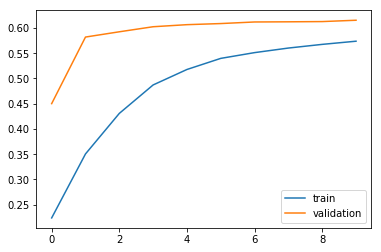

In [83]:
# learning curves of model accuracy
plt.plot(history.history['acc']+history2.history['acc'], label='train')
plt.plot(history.history['val_acc']+history2.history['val_acc'], label='validation')
plt.legend()
plt.show()

In [85]:
# evaluate the model
_, acc_train = model.evaluate(x_train, y_train, verbose=0)
_, acc_test = model.evaluate(x_test, y_test, verbose=0)
print('Train: %.3f, Test: %.3f' % (acc_train, acc_test))

Train: 0.608, Test: 0.440


In [78]:
# evaluate the model
_, acc_train = model.evaluate(x_train, y_train, verbose=0)
_, acc_test = model.evaluate(x_test, y_test, verbose=0)
print('Train: %.3f, Test: %.3f' % (acc_train, acc_test))

Train: 0.585, Test: 0.480
